In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [11]:
data = pd.read_csv(r'E:\pythoncode\titanic\train.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [12]:
#删除缺失值过多的列，和观察判断来说和预测的y没有关系的列
data.drop(['Cabin','Name','Ticket'],inplace=True,axis=1)
#处理缺失值，对缺失值较多的列进行填补，有一些特征值只缺失一两个值，可以采取直接删除记录的方法
data['Age'] =  data['Age'].fillna(data['Age'].mean()) #用平均值进行填补缺失值
data = data.dropna()

#将分类变量转化为数值型变量

#将二分类变量转化为数值型变量
#astype能够将一个pandas对象转换为某种类型，和apply(int(x))不同，astype可以将文本类转换为数字，用这个方式
#可以很便捷地将二分类特征转换为0~1
data['Sex'] = (data['Sex']=='male').astype('int')

In [16]:
#将三分类变量转换为数值型变量
labels = data['Embarked'].unique().tolist()
data['Embarked'] = data['Embarked'].apply(lambda x:labels.index(x))

In [17]:
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,0
1,2,1,1,0,38.0,1,0,71.2833,1
2,3,1,3,0,26.0,0,0,7.9250,0
3,4,1,1,0,35.0,1,0,53.1000,0
4,5,0,3,1,35.0,0,0,8.0500,0


In [19]:
# 提取标签和特征矩阵 分测试集和训练集
x = data.iloc[:,data.columns != "Survived"]
y = data.iloc[:,data.columns == "Survived"]

from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(x,y,test_size = 0.3)

#修正测试集和训练集的索引 原来的索引不是从0开始的
for i in [Xtrain,Xtest,Ytrain,Ytest]:
    i.index = range(i.shape[0])

In [20]:
Xtrain.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,120,3,0,2.000000,4,2,31.2750,0
1,452,3,1,29.699118,1,0,19.9667,0
2,661,1,1,50.000000,2,0,133.6500,0
3,539,3,1,29.699118,0,0,14.5000,0
4,202,3,1,29.699118,8,2,69.5500,0


In [21]:
# 导入模型，粗略跑一下查看结果
clf = DecisionTreeClassifier(random_state=25)
clf.fit(Xtrain,Ytrain)
score_ = clf.score(Xtest,Ytest)

In [23]:
score = cross_val_score(clf,x,y,cv=10).mean()  #交叉验证分数取平均值

In [24]:
score

0.7469611848825333

0.8166624106230849


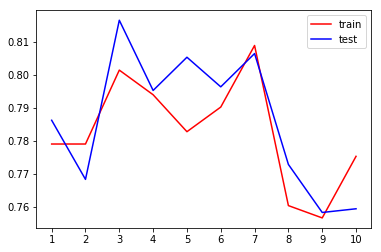

'为什么使用entropy？因为我们注意到在最大深度max_depth=3的时候，模型拟合不足，在训练集和测试集上的表现接近，\n但却不是非常理想，所以使用entropy'

In [28]:
'''在不同的max_depth 下观察模型的拟合程度'''
tr = []
te = []
for i in range(10):
    clf = DecisionTreeClassifier(random_state=25,
                                max_depth=i+1,
                                criterion='entropy'
                                )
    clf.fit(Xtrain,Ytrain)
    score_tr = clf.score(Xtest,Ytest)
    score_te = cross_val_score(clf,x,y,cv=10).mean()
    tr.append(score_tr)
    te.append(score_te)
print(max(te))
plt.plot(range(1,11),tr,color='red',label='train')
plt.plot(range(1,11),te,color='blue',label='test')
plt.xticks(range(1,11))
plt.legend()
plt.show()
'''为什么使用entropy？因为我们注意到在最大深度max_depth=3的时候，模型拟合不足，在训练集和测试集上的表现接近，
但却不是非常理想，所以使用entropy'''

##### 用网格搜索调整参数

In [35]:
import numpy as np
gini_thresholds = np.linspace(0,0.5,20) #gini系数取值0-0.5
entropy_thresholds = np.linspace(0,1,50) #entropy取值0-1

parameters = {'splitter':('best','random')
              ,'criterion':("gini","entropy")
              ,"max_depth":[*range(1,10)]  # *相当于解压 将range(1,10)解压
              ,'min_samples_leaf':[*range(1,50,5)]
              ,'min_impurity_decrease':[*np.linspace(0,0.5,20)]
             }
clf = DecisionTreeClassifier(random_state=25)
#网格搜索：能够帮助我们同时调整多个参数的技术，枚举技术
GS = GridSearchCV(clf,parameters,cv=10)
GS.fit(Xtrain,Ytrain)
print(GS.best_params_)  #从我们输入的参数和参数的取值的列表中，返回最佳组合
print(GS.best_score_) #网格搜索后的模型的评判标准

{'criterion': 'gini', 'max_depth': 3, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'splitter': 'random'}
0.8183279742765274
